In [1]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from CO2_pre_processing import CO2DataPreparation
from pylab import rcParams
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import numpy
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import scipy
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import CO2Evaluator as evaluator
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

# Collect the data
In this section we show how to collect the emissions data for a given time period. 

The data is retrieved from the following url: https://demanda.ree.es/WSvisionaMovilesPeninsulaRest/resources/demandaGeneracionPeninsula?fecha= indicating in the _fecha_ parameter the desired date in format YY-MM-dd. To simplify the process and looking to implement a pipeline in the future, we have created a class to perform all the tasks related with the data extraction.  
This class first use the _collect_data_ method with the start and end dates as parameters and once the data is retrieved we call the _generate_csv_ method which writes the retrieved data in a _CSV_ file for further tasks.

In [3]:
collector = CO2DataCollector()

In [4]:
# Collects the data between two boundaries dates
collector.collect_data('2017-01-01', '2020-05-01')

In [5]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2017_01_01_to_2020_05_01.csv')

At this point the code has generated a _CSV_ file with the emissions between two dates

# Data Cleaning
In this section we will perform some data cleaning tasks so the data is ready for the next phase.  
We will check for:
- Missing Data
- Duplicated dates
- Errors

In [6]:
dataset = pandas.read_csv('Emissions_2017_01_01_to_2020_05_01.csv')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220096 entries, 0 to 220095
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  220096 non-null  int64  
 1   Fecha       220096 non-null  object 
 2   Emisiones   220096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.0+ MB


In [8]:
dataset.head()

,Unnamed: 0,Fecha,Emisiones
0,0,2016-12-31 21:00,9659.81
1,1,2016-12-31 21:10,9627.94
2,2,2016-12-31 22:30,9407.57
3,3,2016-12-31 21:20,9562.48
4,4,2016-12-31 21:30,9545.36


## Check for missing values
We will check for missing values performing a sum of all the missing values for each column

In [9]:
# Perform a sum of all NaN values
dataset.isnull().sum()

Unnamed: 0    0
Fecha         0
Emisiones     0
dtype: int64

There are not missing values in the dataset which is really good

## Check for duplicated dates
In the data extraction phase, each day retrieved starts at 21:00 of the day before and ends at 03:00 of the day after, so when we retrieve various days, the data from 21:00 of the day selected to 03:00 of the day after is duplicated

In [10]:
# Duplicated method outputs on the duplicated dates a True value
dataset.duplicated("Fecha").value_counts()

False    175135
True      44961
dtype: int64

As we can see in the output above, there are 33121 duplicated dates, which are a lot of duplicated data.  
In order to fix this we will use the a _pandas_ function which maintains the dates that it see first in the dataset and deletes the repetitions.

In [11]:
# Drop duplicates on "Fecha" column
dataset = dataset.drop_duplicates("Fecha")

# Outputs the duplicated dates again if they exist
dataset.duplicated("Fecha").value_counts()

False    175135
dtype: int64

Now all the 6000 rows with duplicated dates have been removed.

## Check for errors in dates
Some rows contains an error in the _Fecha_ column, where in the part related to hours there are some characters instead of numbers.  
We will use a regular expression to match any date that contains some character, either upper case or lower case.

In [12]:
# Use regular expression to detect any character in dates
dataset[dataset['Fecha'].str.contains(r'.*[a-zA-Z].*')]

,Unnamed: 0,Fecha,Emisiones
54473,173,2017-10-29 2A:10,5204.88
54474,174,2017-10-29 2A:20,5179.06
54475,175,2017-10-29 2A:30,5215.67
54476,176,2017-10-29 2A:40,5269.39
54477,177,2017-10-29 2A:50,5341.64
54478,178,2017-10-29 2B:00,5256.08
54511,30,2017-10-29 2A:00,5193.95
54518,37,2017-10-29 2B:10,5160.67
54519,38,2017-10-29 2B:20,5145.40
54520,39,2017-10-29 2B:30,5078.43


As we can see is there a problem with the data related to October, the errors only appear in this month. In one case on 28th and in the other one on 27th.  
We will take a look of the data surrounding these dates to see to which hours corresponds the errors

In [13]:
dataset[54465:].head(20)

,Unnamed: 0,Fecha,Emisiones
68414,177,2018-01-14 02:40,7237.97
68415,178,2018-01-14 02:50,7096.81
68416,179,2018-01-14 03:00,7056.00
68417,180,2018-01-14 02:10,7642.58
68455,37,2018-01-14 03:10,7077.92
68456,38,2018-01-14 03:20,7110.84
68457,39,2018-01-14 03:30,7031.07
68458,40,2018-01-14 03:40,7010.57
68459,41,2018-01-14 03:50,6951.23
68460,42,2018-01-14 04:00,6933.08


If wee try to see the surrounding rows of the errors by accesing by index it returns the wrong index, that means the index is broken maybe due to remove duplicated dates, so in order to fix it we will reset the index. A new index will be assign with correct numbers

In [14]:
# Reset the index
dataset = dataset.reset_index()

In [15]:
# Use regular expression to detect any character in dates
dataset[dataset['Fecha'].str.contains(r'.*[a-zA-Z].*')]

,index,Unnamed: 0,Fecha,Emisiones
43367,54473,173,2017-10-29 2A:10,5204.88
43368,54474,174,2017-10-29 2A:20,5179.06
43369,54475,175,2017-10-29 2A:30,5215.67
43370,54476,176,2017-10-29 2A:40,5269.39
43371,54477,177,2017-10-29 2A:50,5341.64
43372,54478,178,2017-10-29 2B:00,5256.08
43374,54511,30,2017-10-29 2A:00,5193.95
43375,54518,37,2017-10-29 2B:10,5160.67
43376,54519,38,2017-10-29 2B:20,5145.40
43377,54520,39,2017-10-29 2B:30,5078.43


In [16]:
dataset[43355:].head(50)

,index,Unnamed: 0,Fecha,Emisiones
43355,54461,161,2017-10-29 00:00,5722.91
43356,54462,162,2017-10-29 00:10,5769.04
43357,54463,163,2017-10-29 00:20,5721.38
43358,54464,164,2017-10-29 00:30,5781.50
43359,54465,165,2017-10-29 00:40,5592.58
43360,54466,166,2017-10-29 00:50,5482.71
43361,54467,167,2017-10-29 01:00,5608.10
43362,54468,168,2017-10-29 01:10,5672.29
43363,54469,169,2017-10-29 01:20,5569.84
43364,54470,170,2017-10-29 01:30,5383.31


Now we can see the correct rows, also it seems the data might be unordered, so we will sort it by the datetime index, but first the errors must be handled. Looking the data it seems the rows with character _A_ belongs to 02 hours and rows with character _B_ looks like errors.  
So in order to fix this, we will replace the 2A by a 02 and remove the rows which contains a 2B.

In [17]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')

# Use the NOT simbol (~) to return the dataset without rows containing a 2B
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [18]:
dataset[43350:].head(50)

,index,Unnamed: 0,Fecha,Emisiones
43350,54456,156,2017-10-28 23:10,5899.12
43351,54457,157,2017-10-28 23:20,5937.23
43352,54458,158,2017-10-28 23:30,5787.67
43353,54459,159,2017-10-28 23:40,5772.36
43354,54460,160,2017-10-28 23:50,5724.13
43355,54461,161,2017-10-29 00:00,5722.91
43356,54462,162,2017-10-29 00:10,5769.04
43357,54463,163,2017-10-29 00:20,5721.38
43358,54464,164,2017-10-29 00:30,5781.50
43359,54465,165,2017-10-29 00:40,5592.58


Now the error seems fixed. The problem with the order will be fixed in the _Data Preparation_ section, where the _Fecha_ column will be converted into a datetime object, then set it as index and sort the dataset by index

## Drop unused columns  
As we can see in the dataset view above, the dataset contains two unused columns generated by default: _index_ and _Unnamed: 0_ so we will remove it from the dataset

In [19]:
# Drop the "Unnamed: 0" and "index" column
dataset = dataset.drop(['Unnamed: 0', 'index'], axis=1)

In [20]:
dataset.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00,9659.81
1,2016-12-31 21:10,9627.94
2,2016-12-31 22:30,9407.57
3,2016-12-31 21:20,9562.48
4,2016-12-31 21:30,9545.36
5,2016-12-31 21:50,9442.41
6,2016-12-31 22:10,9514.21
7,2016-12-31 21:40,9494.49
8,2016-12-31 22:20,9448.20
9,2016-12-31 22:00,9420.89


# Data Preparation
In this section we will perform some tasks on the data in order to prepare it for the analysis.  
The time series data is special, it must meet certain conditions:
- The dates column must be a datetime object instead of other data types
- The index of the dataset must be the dates column  

Once the steps before are completed, the dataset must be sorted by the index since as we have seen in the last section, it is unordered

In [21]:
# Converts the timestamp column to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])

# Sets the timestamp column as index
dataset = dataset.set_index('Fecha')

# Sort the dataset by index
dataset = dataset.sort_index()

In [22]:
dataset.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49
2016-12-31 21:50:00,9442.41
2016-12-31 22:00:00,9420.89
2016-12-31 22:10:00,9514.21
2016-12-31 22:20:00,9448.20


Now the data meets the right conditions to be analysed. The frequency of the data is 10 minutes, which for our specific problem is a low frequency, so we will change it to a hourly frequency

## Change frequency
We will create a new dataset with an hourly frequency.  
First we will check the frequency of the actual dataset and if it is set to none, we will assign a _10 min_ frequency to it.

In [23]:
# Show the actual frequency
print(dataset.index.freq)

None


The frequency is _None_ so we have to add a _10 min_ frequency in order to change it in the future.

In [24]:
# Set a frequency to the data
dataset = dataset.asfreq('10min')

In [25]:
print(dataset.index.freq)

<10 * Minutes>


Now the dataset has the right frequency, but some missing values might have been generated.

In [26]:
# Check the missing values
dataset.isnull().sum()

Emisiones    24
dtype: int64

In [27]:
# Use interpolation taking account of the time
dataset = dataset.interpolate(method='time')

In [28]:
dataset.isnull().sum()

Emisiones    0
dtype: int64

At this point the dataset has the right frequency setted and there are not missing values, so we will proceed to resample it to an hourly frequency.  
We will use the _resample_ method which generates a _Resampler_ object which can be applied a _sum_ function to generate a series where each hour has the sum of all emissions at the hour.

In [29]:
# Resample the dataset with a new frequency
hourly_series = dataset['Emisiones'].resample('H').sum()

In [30]:
# Create a new dataset with the sum of Emissions as values and an index with hourly frequency
hourly_dataset = pandas.DataFrame({'Emisiones':hourly_series.values}, index=hourly_series.index)

In [31]:
# New missing values may have been generated
hourly_dataset.isnull().sum()

Emisiones    0
dtype: int64

In [32]:
hourly_dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97


## Creation of CSV files
We will create a csv file with the data ready for the analysis.

In [36]:
# We set the index as false because we don't want default index to be created
hourly_dataset.to_csv("Emissions_2017_01_01_to_2020_05_01_Prepared.csv")

# Data Analysis
In this section we will perform an analysis to a dataset which starts on January of 2017 and ends on May of 2020, not included the last.  
The objectives for this analysis are:
- Discover the type of time series (multiplicative or additive)
- Determine if the series are stationary or non-stationary

In [2]:
dataset_by_hour = pandas.read_csv('Emissions_2017_01_01_to_2020_05_01_Prepared.csv')

In [3]:
dataset_by_hour.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97
5,2017-01-01 02:00:00,53940.48
6,2017-01-01 03:00:00,51843.22
7,2017-01-01 04:00:00,50390.88
8,2017-01-01 05:00:00,49331.71
9,2017-01-01 06:00:00,48633.39


As we can see tha data doesn't have the _Fecha_ column, that is because the _CSV_ files cannot save datetime objects so it set _Fecha_ as another column and as a string type.  
So we will have to apply the following tasks:
- Convert _Fecha_ to a datetime object 
- Set _Fecha_ as the index of the dataset

The frequency of the data will be _None_ so we must to infer it, and set it to the dataset through the _freq_ attribute from the index

In [4]:
# Convert Fecha into a datetime object
dataset_by_hour['Fecha'] = pandas.to_datetime(dataset_by_hour['Fecha'])
# Set the new index
dataset_by_hour = dataset_by_hour.set_index('Fecha')

In [5]:
dataset_by_hour.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97


We will use the _infer_freq_ method to infer the frequency, if it returns the frequency it means that the dates are regularly separated, in other case it returns _None_

In [6]:
# Infer the frequency and assign it to a variable
dataset_frequency = pandas.infer_freq(dataset_by_hour.index)
dataset_frequency

'H'

In [7]:
# Set the frequency
dataset_by_hour.index.freq = dataset_frequency

In [8]:
# Output the index
dataset_by_hour.index

DatetimeIndex(['2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00',
               '2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               ...
               '2020-04-30 18:00:00', '2020-04-30 19:00:00',
               '2020-04-30 20:00:00', '2020-04-30 21:00:00',
               '2020-04-30 22:00:00', '2020-04-30 23:00:00',
               '2020-05-01 00:00:00', '2020-05-01 01:00:00',
               '2020-05-01 02:00:00', '2020-05-01 03:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=29191, freq='H')

Now the index meets the right conditions, its data type is a datetime object and it has the right frequency

## Visualize Charts
We will plot a line chart to detect possible seasonal patterns in the data and an histogram to see the distribution of the data

In [9]:
# Set a custom style for the charts
pyplot.style.use('fivethirtyeight')

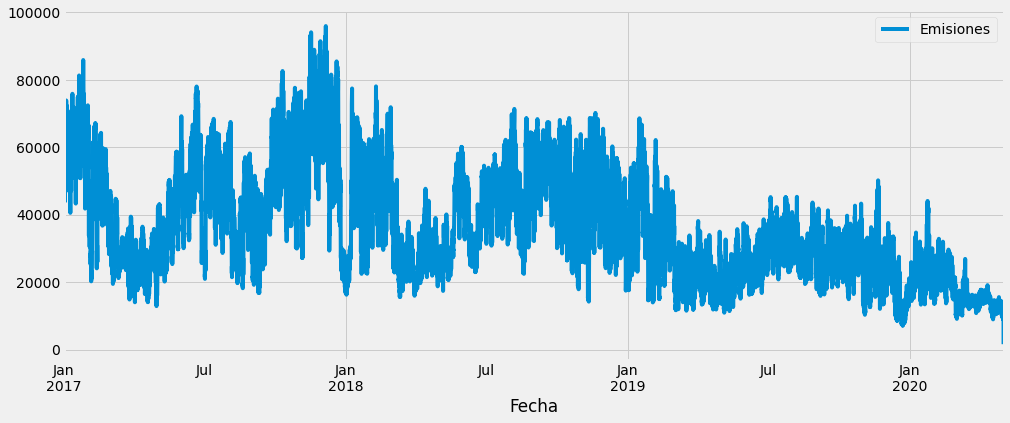

In [10]:
dataset_by_hour.plot(figsize=(15, 6))

**-** If we look each year separatedly, we can see that at the end and start of the year (Winter Season) there are higher number of emissions which might be due to the weather, because there are only a few sun hours per day, thus the solar energy sources cannot generate much energy, so we have to use other non-renovable energy sources to fix that.  

**-** Following the sense of the above assumption, on the Spring season we can see that emissions decrease, it might be because the people doesn't need heating in their houses so less energy is needed and the increased rains and wind help other renovable energy sources.  

**-** On summer it increases again because summer in Spain is so hot and the people need air conditioning, which means in an increment of energy needed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002656D319A48>]],
      dtype=object)

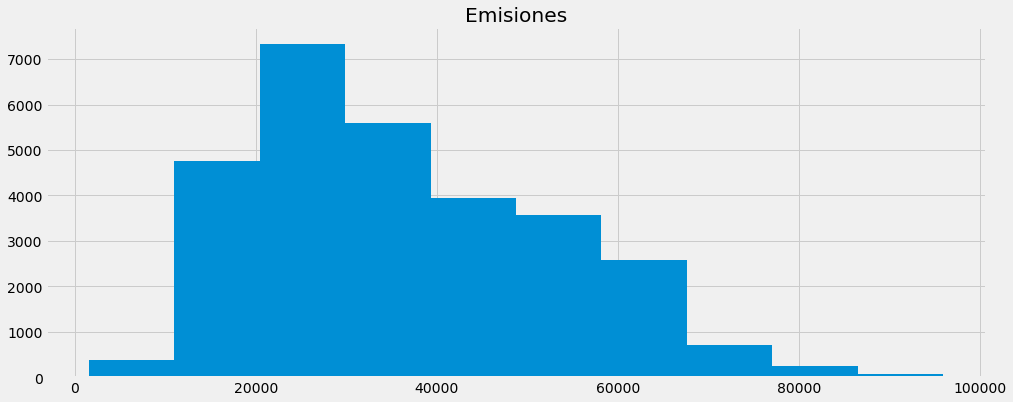

In [11]:
dataset_by_hour.hist(figsize=(15, 6))

Looking the histogram, we can see that the data doesn't follow a normal distribution, the distribution is positive skewed. So we will have to apply some transformation in order to get a normal distribution of the data, in the case of positive skewed distributions the most common transformation is the log transformation, which applies a logarithm to each value.


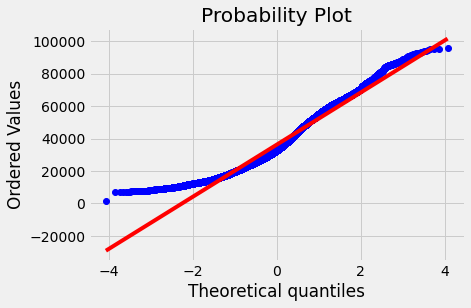

In [12]:
scipy.stats.probplot(dataset_by_hour['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

## Decompose the series

Now we will decompose the series into its constituient components to determine if it is additive or multiplicative.

**Additive Series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Series:**
Value = Base Level * Trend * Seasonality * Error

It seems that the dataset is a multiplicative series because of it seems to be non-linear, the seasonality has different frequency and amplitude over time, we will plot both models and confirm this hypotheses

Our dataset has 29191 obervations

In [12]:
## If our dataset would not have a specific frequency, we would have to add the period parameter.
# Multiplicative Decomposition
result_mul = seasonal_decompose(dataset_by_hour, model='multiplicative')
# Additive Decomposition
result_add = seasonal_decompose(dataset_by_hour, model='additive')

In [17]:
type(result_mul)

statsmodels.tsa.seasonal.DecomposeResult

In [29]:
# Set the figsize
rcParams['figure.figsize'] = 20, 12

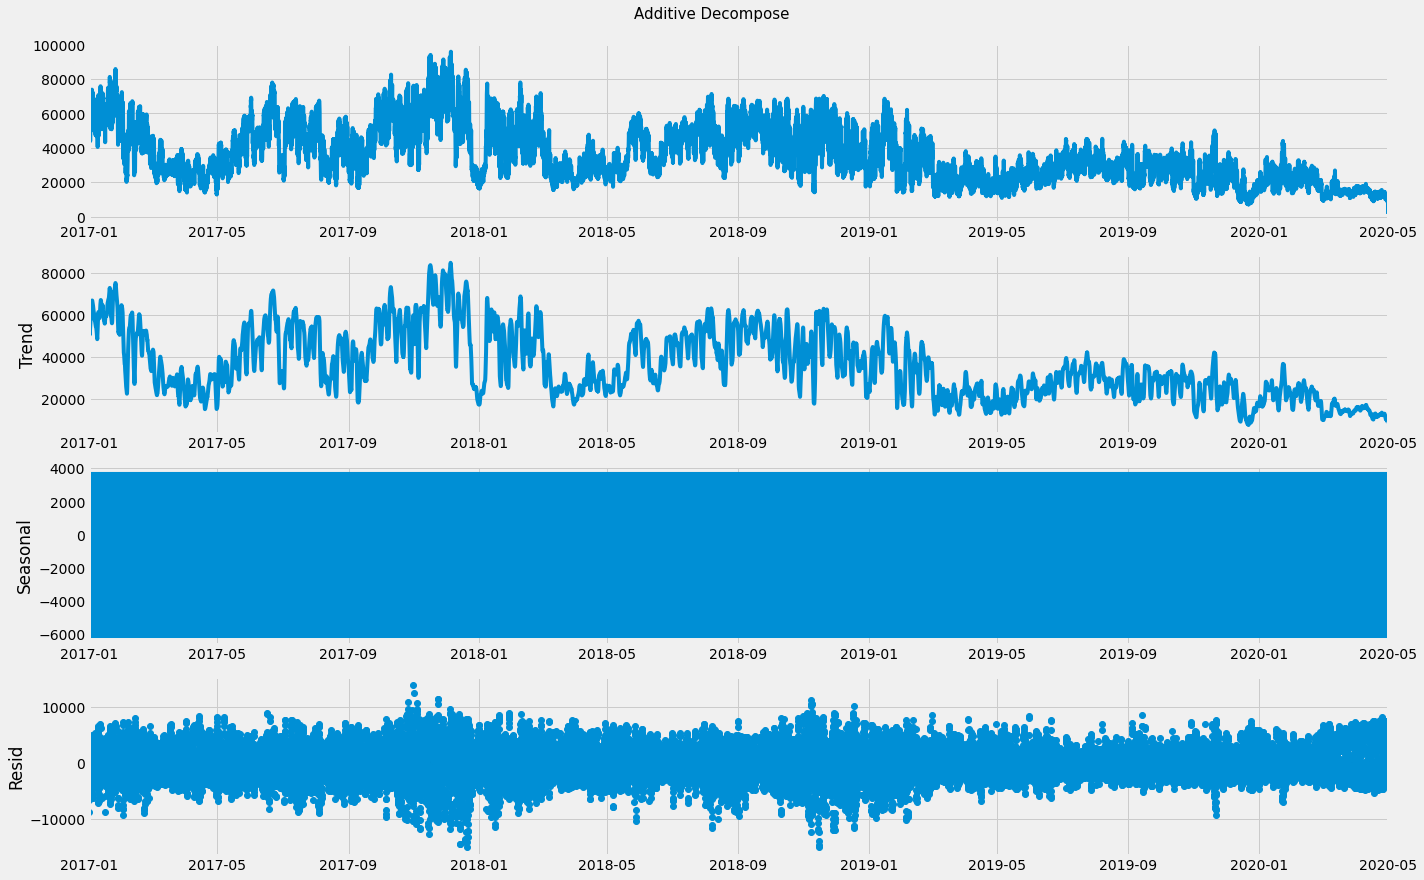

In [30]:
# Plot additive decomposition
result_add.plot().suptitle('Additive Decompose', fontsize=15, y=1.02)
pyplot.show()

In [66]:
result_add.resid

Fecha
2016-12-31 21:00:00   NaN
2016-12-31 22:00:00   NaN
2016-12-31 23:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 01:00:00   NaN
                       ..
2020-04-30 23:00:00   NaN
2020-05-01 00:00:00   NaN
2020-05-01 01:00:00   NaN
2020-05-01 02:00:00   NaN
2020-05-01 03:00:00   NaN
Freq: H, Name: resid, Length: 29191, dtype: float64

In [58]:
prueba_mul = result_mul.trend + result_mul.seasonal + result_mul.resid

In [63]:
result_mul.resid

Fecha
2016-12-31 21:00:00   NaN
2016-12-31 22:00:00   NaN
2016-12-31 23:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 01:00:00   NaN
                       ..
2020-04-30 23:00:00   NaN
2020-05-01 00:00:00   NaN
2020-05-01 01:00:00   NaN
2020-05-01 02:00:00   NaN
2020-05-01 03:00:00   NaN
Freq: H, Name: resid, Length: 29191, dtype: float64

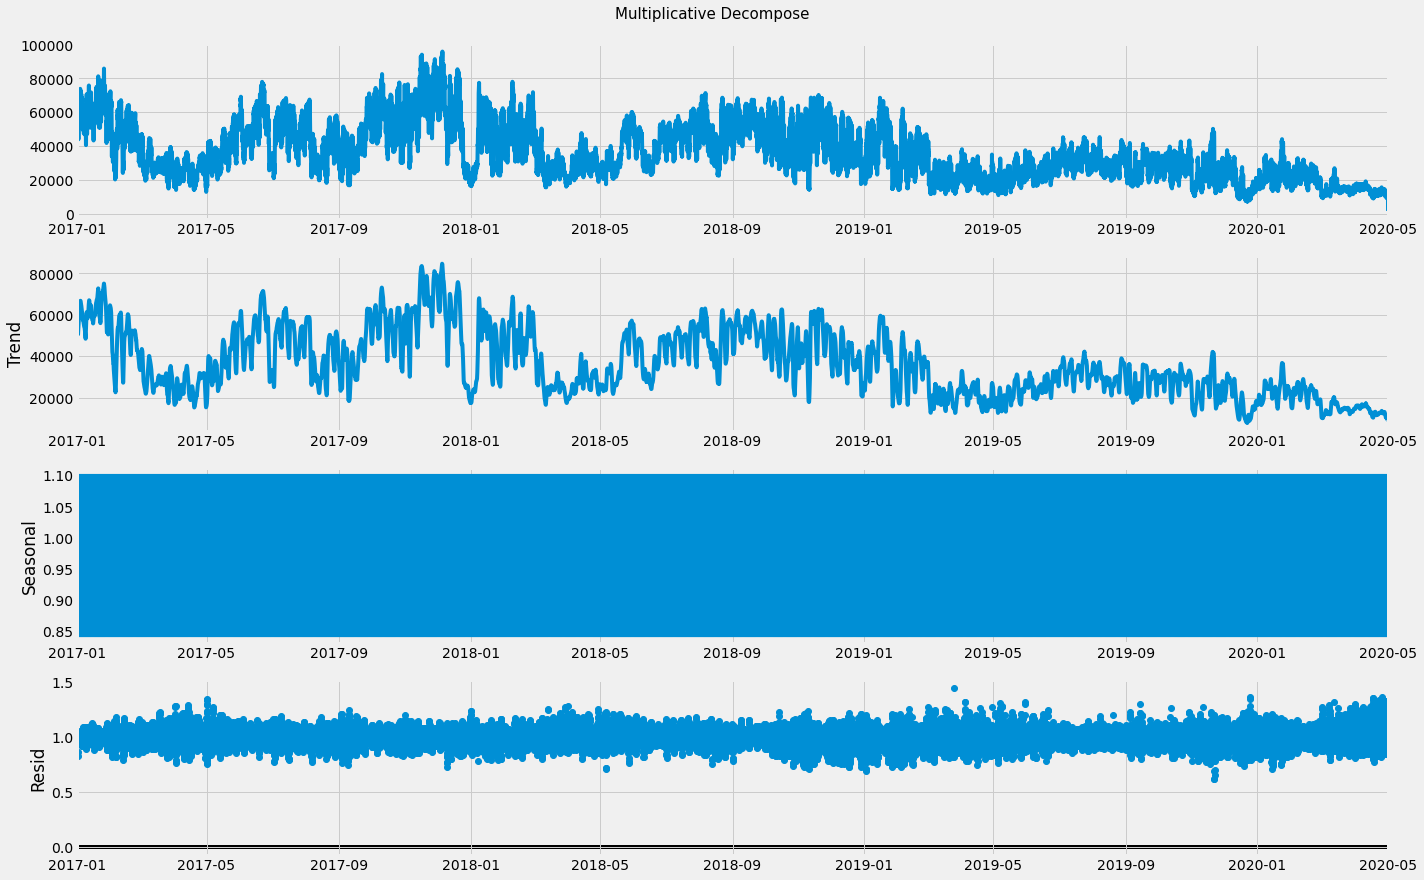

In [31]:
# Plot multiplicative decomposition
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15, y=1.02)
pyplot.show()

## STL Decompose

In [13]:
# Set the figsize
rcParams['figure.figsize'] = 16, 13

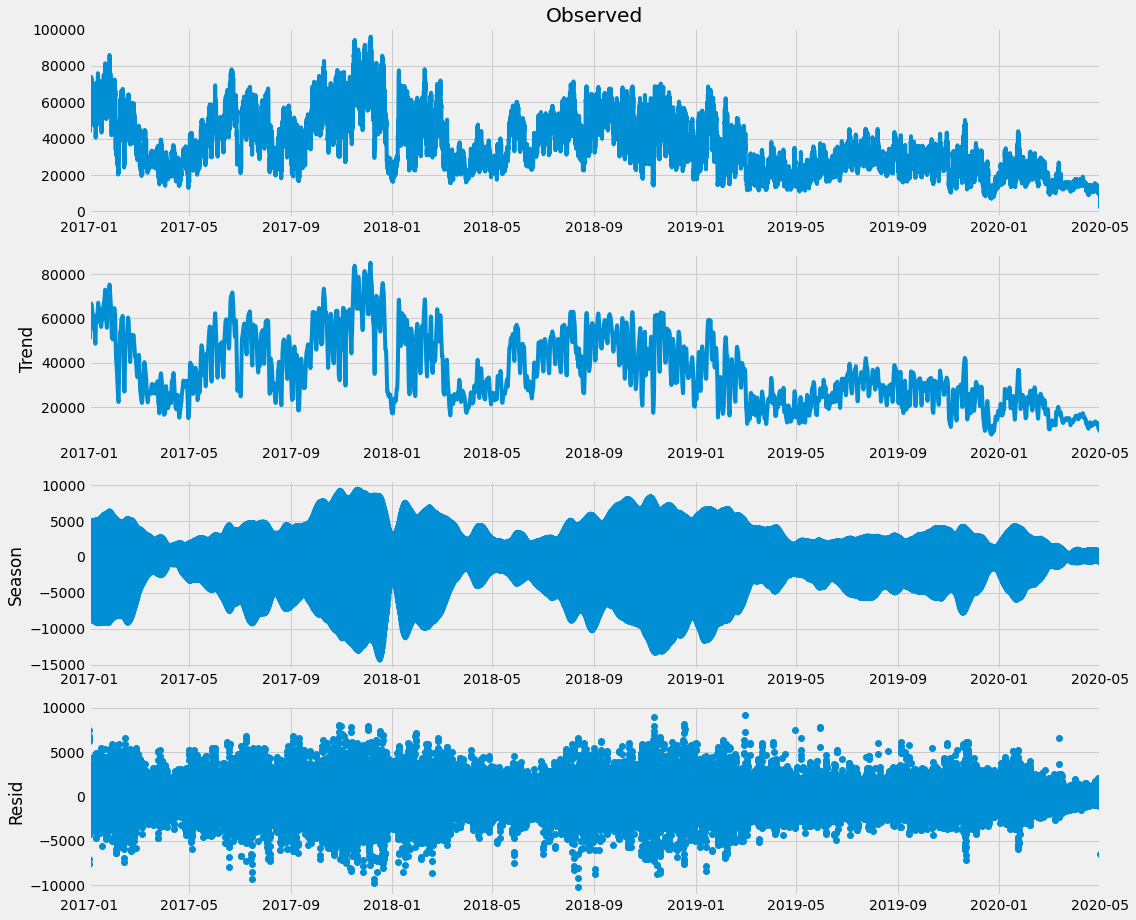

In [15]:
stl = STL(dataset_by_hour, seasonal=25, robust=False)
res = stl.fit()
fig = res.plot()

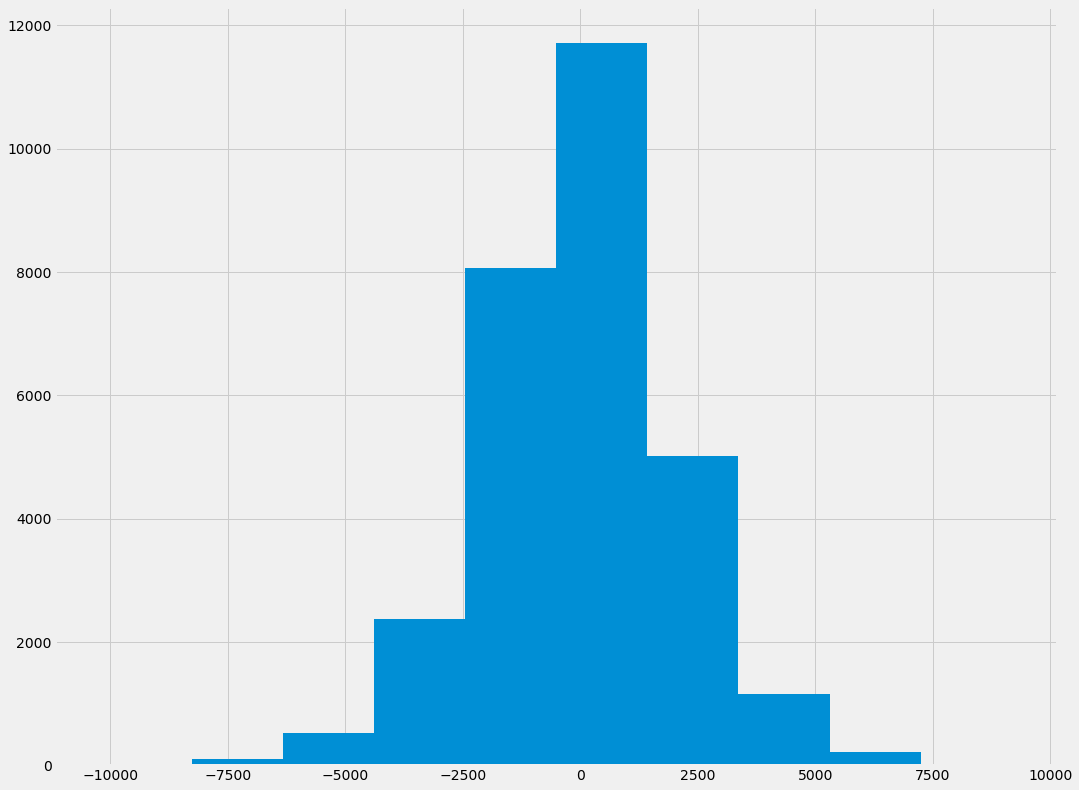

In [16]:
res.resid.hist()

In [142]:
prueba = res.trend + res.resid

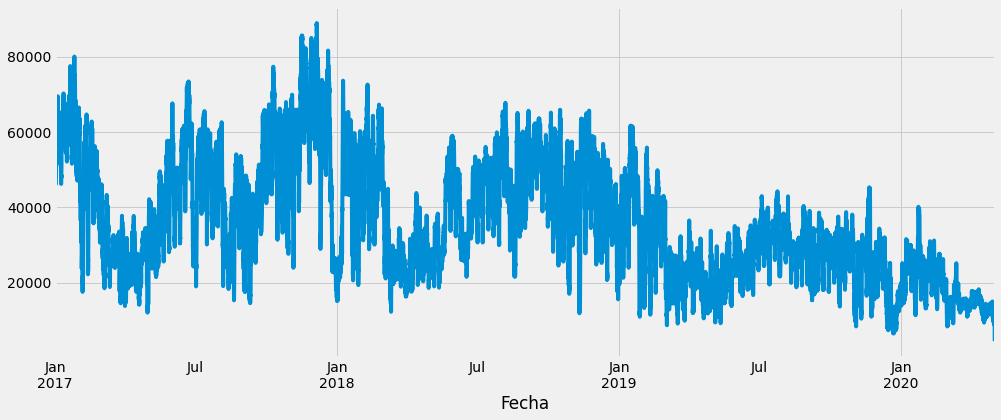

In [143]:
prueba.plot(figsize=(15, 6))

In [76]:
prueba

Fecha
2016-12-31 21:00:00    57332.49
2016-12-31 22:00:00    56671.33
2016-12-31 23:00:00    57666.70
2017-01-01 00:00:00    57684.04
2017-01-01 01:00:00    56670.97
                         ...   
2020-04-30 23:00:00     9904.88
2020-05-01 00:00:00    10204.43
2020-05-01 01:00:00     9643.01
2020-05-01 02:00:00     9493.11
2020-05-01 03:00:00     1574.35
Freq: H, Length: 29191, dtype: float64

In [82]:
dataset_prueba = dataset_by_hour.copy()
dataset_prueba['Emisiones'] = numpy.log(dataset_prueba['Emisiones'])

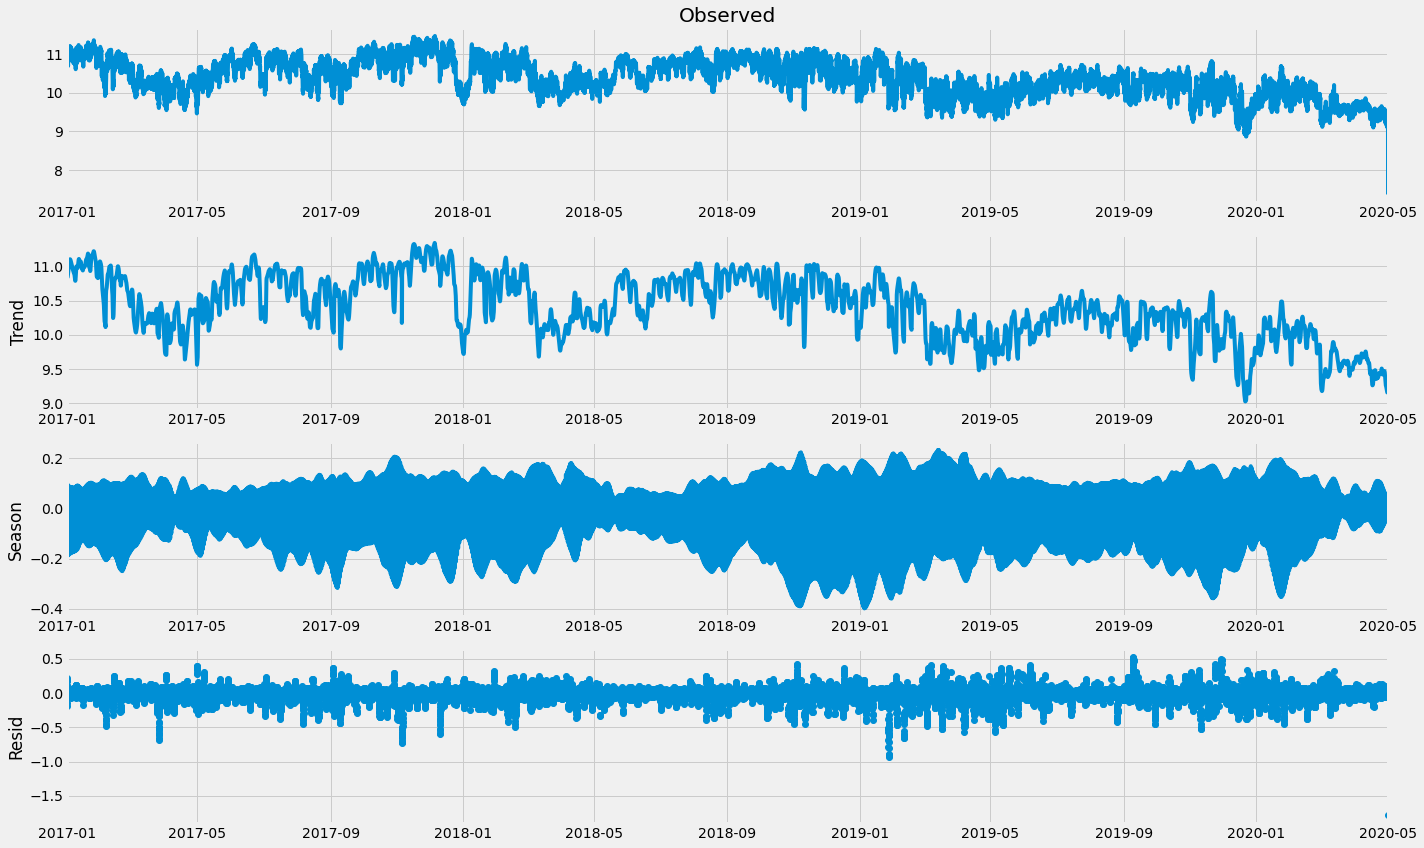

In [84]:
stl_log = STL(dataset_prueba, seasonal=13, robust=True)
res_log = stl_log.fit()
fig_log = res_log.plot()

In [86]:
prueba_log = res_log.trend + res_log.resid + res_log.seasonal

In [90]:
numpy.exp(prueba_log)

Fecha
2016-12-31 21:00:00    57332.49
2016-12-31 22:00:00    56671.33
2016-12-31 23:00:00    57666.70
2017-01-01 00:00:00    57684.04
2017-01-01 01:00:00    56670.97
                         ...   
2020-04-30 23:00:00     9904.88
2020-05-01 00:00:00    10204.43
2020-05-01 01:00:00     9643.01
2020-05-01 02:00:00     9493.11
2020-05-01 03:00:00     1574.35
Freq: H, Length: 29191, dtype: float64

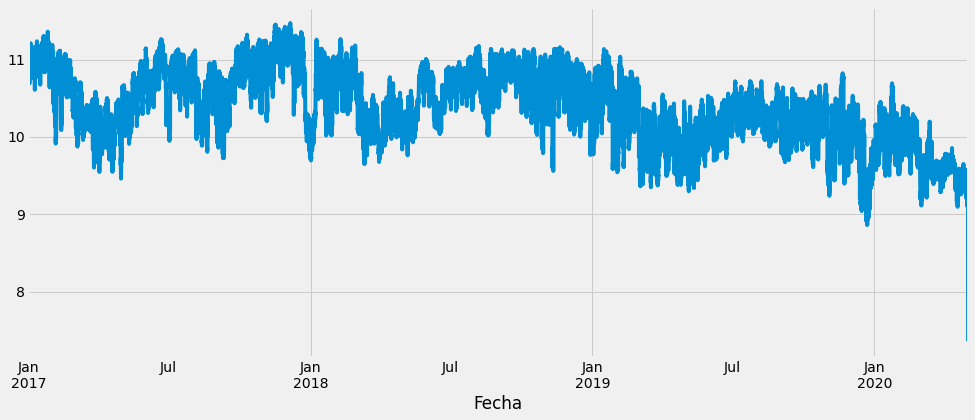

In [93]:
prueba_log.plot(figsize=(15, 6))

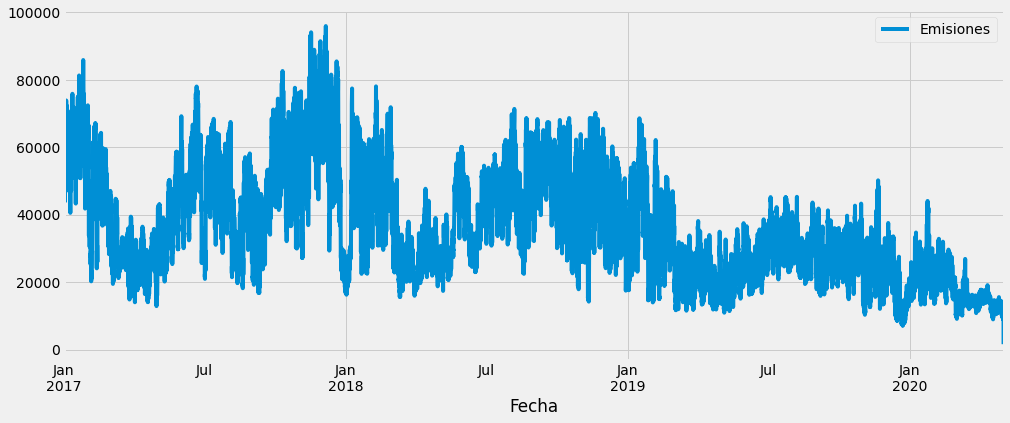

In [53]:
dataset_by_hour.plot(figsize=(15, 6))

# SMOOTHING

In [23]:
smooth_dataset_train = dataset_by_hour[:"2020-03-31"].copy()
smooth_dataset_test = dataset_by_hour["2020-04-01":].copy()

In [101]:
smooth_normal = ExponentialSmoothing(smooth_dataset_train, trend="mul", seasonal="mul", seasonal_periods=8760)
smooth_dump = ExponentialSmoothing(smooth_dataset_train, trend="mul", seasonal="mul", seasonal_periods=8760, damped=True)

In [102]:
result_normal = smooth_normal.fit(use_boxcox=True)
result_dump = smooth_dump.fit(use_boxcox=True)

D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [103]:
pred_normal = result_normal.forecast(48)
pred_dump = result_dump.forecast(48)

In [104]:
pred_dump

2020-04-01 00:00:00    15313.728508
2020-04-01 01:00:00    15735.715200
2020-04-01 02:00:00    15712.953204
2020-04-01 03:00:00    15945.335079
2020-04-01 04:00:00    16155.466669
2020-04-01 05:00:00    16318.389122
2020-04-01 06:00:00    16134.239915
2020-04-01 07:00:00    16282.985407
2020-04-01 08:00:00    15328.488492
2020-04-01 09:00:00    15275.482347
2020-04-01 10:00:00    14671.693965
2020-04-01 11:00:00    14072.295010
2020-04-01 12:00:00    14238.143479
2020-04-01 13:00:00    14597.624810
2020-04-01 14:00:00    14537.925451
2020-04-01 15:00:00    14095.186246
2020-04-01 16:00:00    13320.422323
2020-04-01 17:00:00    12612.256204
2020-04-01 18:00:00    12623.299364
2020-04-01 19:00:00    13482.526089
2020-04-01 20:00:00    14803.317377
2020-04-01 21:00:00    16073.219355
2020-04-01 22:00:00    16378.100954
2020-04-01 23:00:00    16075.062562
2020-04-02 00:00:00    15426.239630
2020-04-02 01:00:00    15861.433372
2020-04-02 02:00:00    16271.167733
2020-04-02 03:00:00    17320

In [105]:
metrics_normal = evaluator.regression_perfomance_metrics(smooth_dataset_test["2020-04-01"], pred_normal["2020-04-01"])
metrics_normal

{'MAE': 1112.7191635702295,
 'MSE': 1831016.898369779,
 'RMSE': 1353.150730099858,
 'R^2': -0.9836647613996139,
 'MAPE': 8.935760184903716}

In [106]:
metrics_dump = evaluator.regression_perfomance_metrics(smooth_dataset_test["2020-04-01"], pred_dump["2020-04-01"])
metrics_dump

{'MAE': 1037.2986532217885,
 'MSE': 1677110.7642228056,
 'RMSE': 1295.0331131761866,
 'R^2': -0.816927810395824,
 'MAPE': 8.653199244474903}

In [107]:
metrics_normal_full = evaluator.regression_perfomance_metrics(smooth_dataset_test["2020-04-01":"2020-04-02"], pred_normal["2020-04-01":"2020-04-02"])
metrics_normal_full

{'MAE': 5388.983911249127,
 'MSE': 60417060.709016405,
 'RMSE': 7772.841224997228,
 'R^2': -57.06893565767017,
 'MAPE': 34.870707816116514}

In [108]:
metrics_normal_dump = evaluator.regression_perfomance_metrics(smooth_dataset_test["2020-04-01":"2020-04-02"], pred_dump["2020-04-01":"2020-04-02"])
metrics_normal_dump

{'MAE': 4899.641400421814,
 'MSE': 49514154.2830958,
 'RMSE': 7036.629468935806,
 'R^2': -46.589773574998745,
 'MAPE': 31.655150970708384}

## Create Dataset to Analyze

In [9]:
dataset_to_analyze = dataset_by_hour.copy()

In [10]:
statistic, p_value, n_lags, critical_values = kpss(dataset_to_analyze)

D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [11]:
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


KPSS Statistic: 20.237977758829143
p-value: 0.01
num lags: 50
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [12]:
p_value

0.01

## Stationary Test (Dickey-Fuller Test)
The Dickey-Fuller Test is a type of unit root test. The intuition vehind is that it determines how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

   **Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

   **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
   
The output is an ADF value and a p-value. The ADF number should be a negative number and the p-value should be beneath a certain threshold value (e.g., 1% or 5%, etc) for a confidence level. For this example, we’ll use 5% (or 95% confidence level), so:

If the **p-value > 0.05**: Fail to reject the null hypothesis because the data has a unit root and is non-stationary.

If the **p-value <= 0.05**: Reject the null hypothesis because the data does not have a unit root and is stationary. 

Also, we have to compare the ADF value with the critical values for 99%, 90% and 95% confidence levels

In [11]:
diff_df = dataset_to_analyze.diff(24)

In [12]:
diff_df

,Emisiones
Fecha,
2016-12-31 21:00:00,NaN
2016-12-31 22:00:00,NaN
2016-12-31 23:00:00,NaN
2017-01-01 00:00:00,NaN
2017-01-01 01:00:00,NaN
...,...
2020-04-30 23:00:00,290.68
2020-05-01 00:00:00,79.97
2020-05-01 01:00:00,-343.84


In [13]:
diff_df = diff_df.interpolate(method='time')

In [14]:
diff_df = diff_df[24:]

In [10]:
# Apply the test on series values
test_result = adfuller(dataset_by_hour, autolag='AIC')

# Output the results
print('ADF Statistic: %f' % test_result[0])
print(f'p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.457613
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [18]:
test_result[1]

1.599029127668354e-13

It is strange because the plots shows that the data is non-stationary but this outputs shows the contray:
- A small p-value, smaller than 0.05 so the Null Hypothesis is rejected
- The test value -8.96 is smaller than the 1% confidence value -3.431

In [21]:
diff_log = dataset_log.diff()
diff_log = diff_log[1:]

In [22]:
diff_log.isnull().sum()

Emisiones    0
dtype: int64

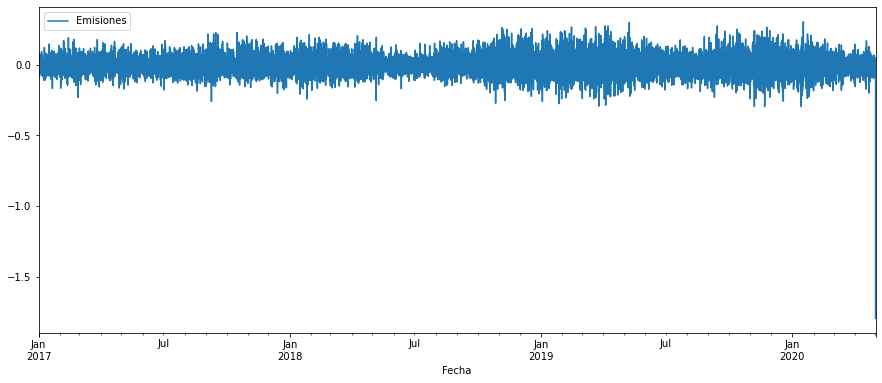

In [24]:
diff_log.plot(figsize=(15, 6))

In [21]:
# Set the figsize
rcParams['figure.figsize'] = 15, 6

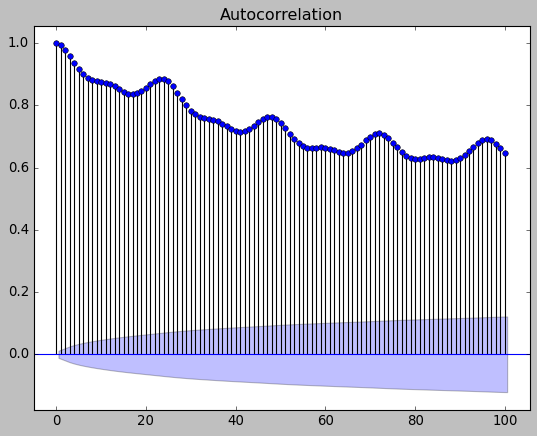

In [30]:
fig = plot_acf(dataset_to_analyze, lags=100)

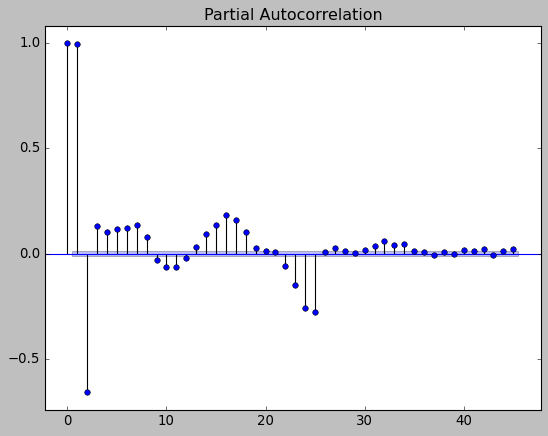

In [27]:
fig2 = plot_pacf(dataset_to_analyze)

In [26]:
pyplot.style.use('classic')

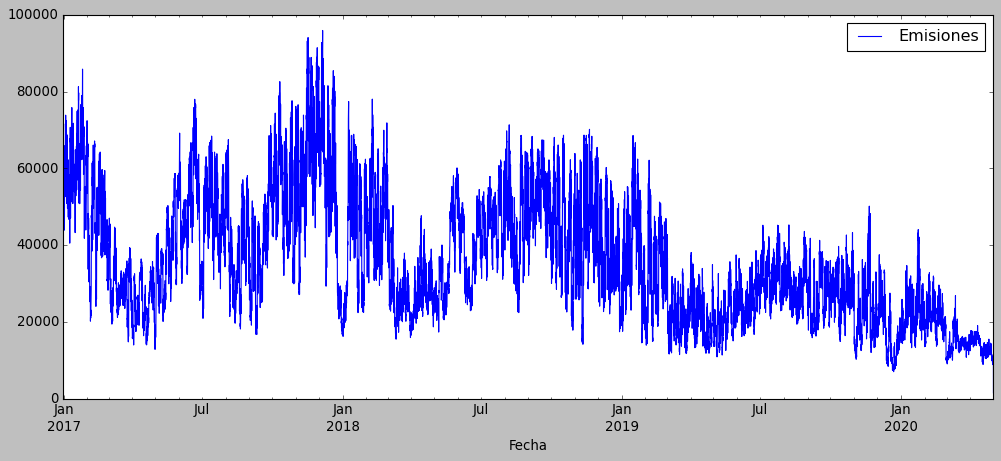

In [31]:
dataset_to_analyze.plot(figsize=(15, 6))

There are still some seasonal component

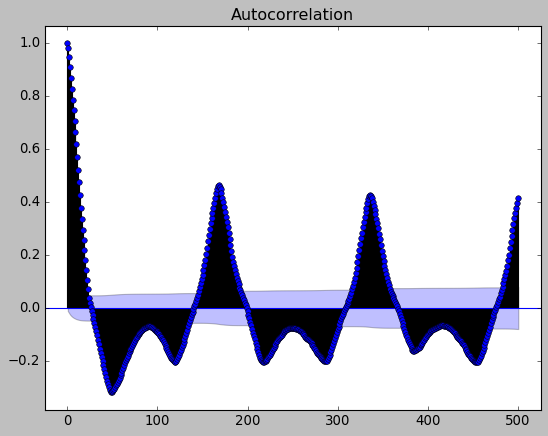

In [81]:
fig = plot_acf(diff_df, lags=500)

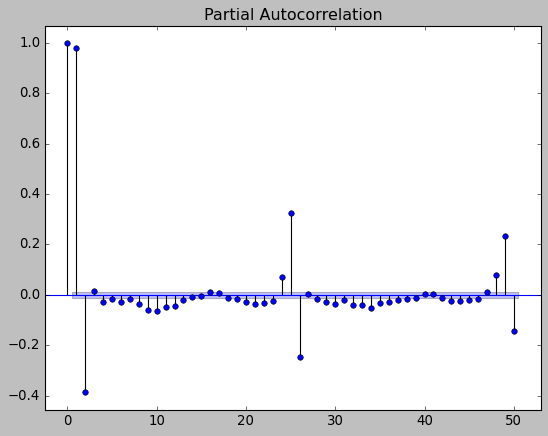

In [79]:
fig2 = plot_pacf(diff_df, lags=50)

## Descriptive Statistics

In [28]:
dataset_by_hour['2017'].describe()

,Emisiones
count,8760.000000
mean,46136.766522
std,16886.726219
min,12867.380000
25%,31650.277500
50%,45711.010000
75%,58993.380000
max,95923.450000


In [29]:
dataset_by_hour['2018'].describe()

,Emisiones
count,8760.000000
mean,41693.040370
std,13457.156178
min,14201.730000
25%,30015.450000
50%,41585.830000
75%,52322.962500
max,78040.780000


In [30]:
dataset_by_hour['2019'].describe()

,Emisiones
count,8760.000000
mean,27024.231106
std,9942.149463
min,7060.530000
25%,19767.120000
50%,26070.025000
75%,32861.232500
max,68570.400000


### Transformations

Now we will apply some transformations to the data in order to apply the test again and see if it is stationary

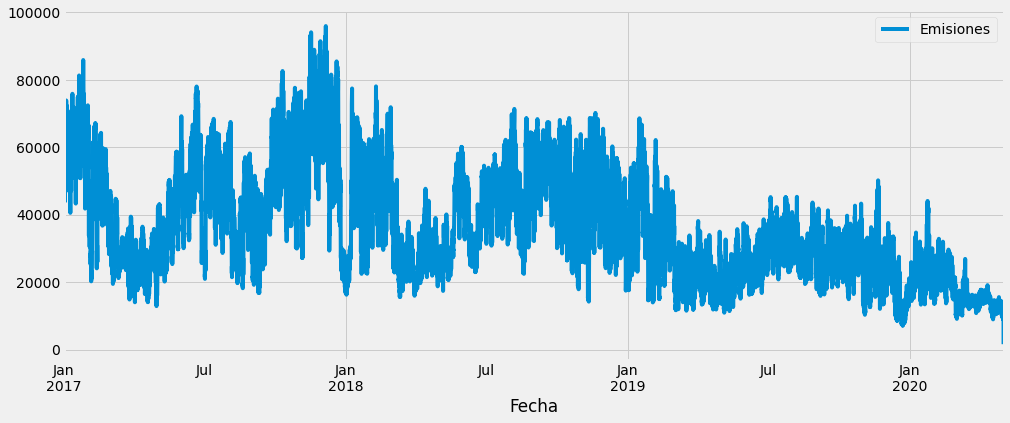

In [19]:
pyplot.rcParams['figure.figsize']=(15, 6)
# line plot
dataset_to_analyze.plot()

It shows a decreasing trend so it is non-stationary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000259819C7748>]],
      dtype=object)

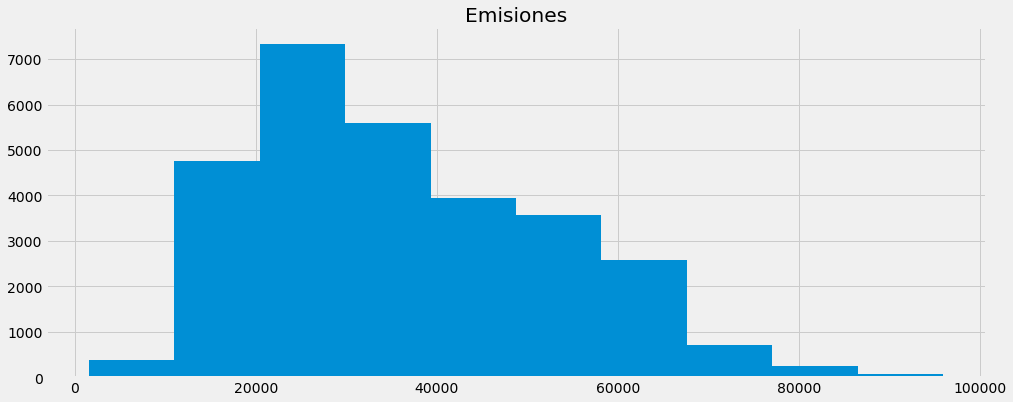

In [20]:
dataset_to_analyze.hist()

Looking the histogram, it doesn't have a normal distribution so it is clearly non-stationary 

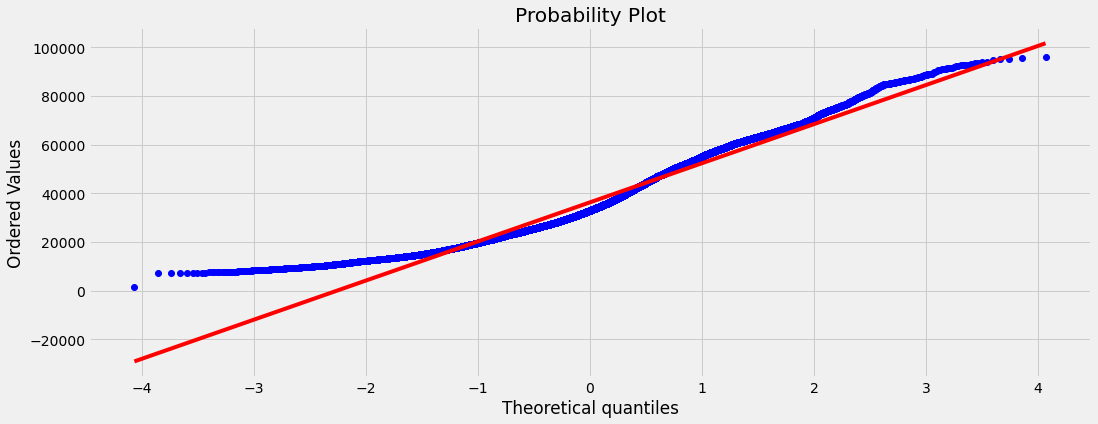

In [53]:
scipy.stats.probplot(dataset_to_analyze['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Square Root Transform

In [114]:
dataset_sqrt = dataset_to_analyze.copy()
dataset_sqrt['Emisiones'] = numpy.sqrt(dataset_sqrt['Emisiones'])

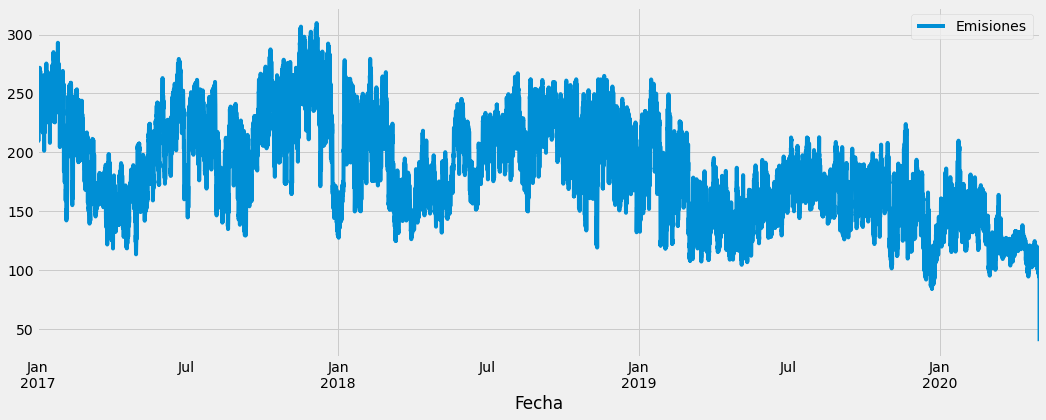

In [115]:
# line plot
dataset_sqrt.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181011A0788>]],
      dtype=object)

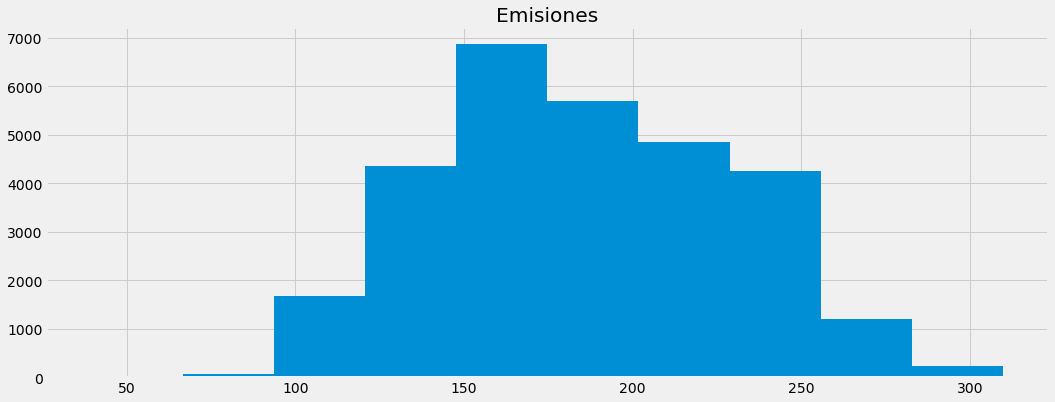

In [116]:
dataset_sqrt.hist()

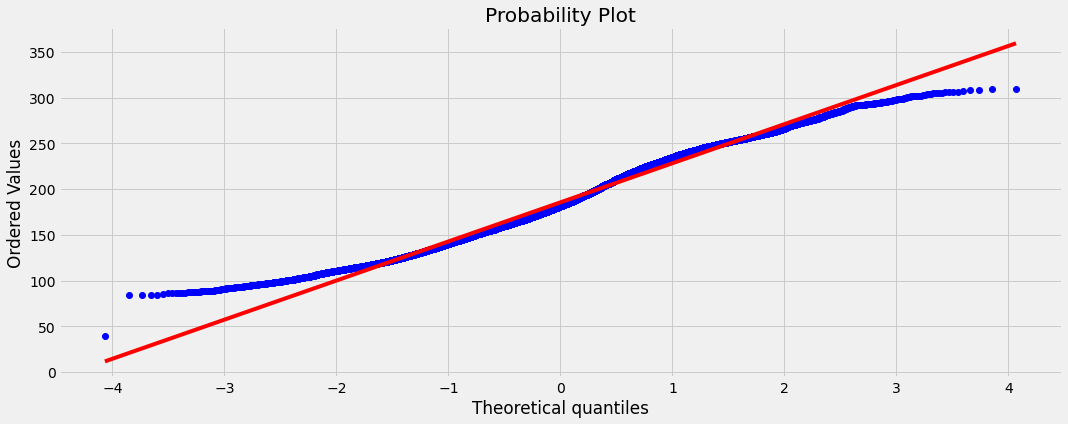

In [117]:
scipy.stats.probplot(dataset_sqrt['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Logarithm Transform

In [11]:
dataset_log = dataset_by_hour.copy()
dataset_log['Emisiones'] = numpy.log(dataset_log['Emisiones'])

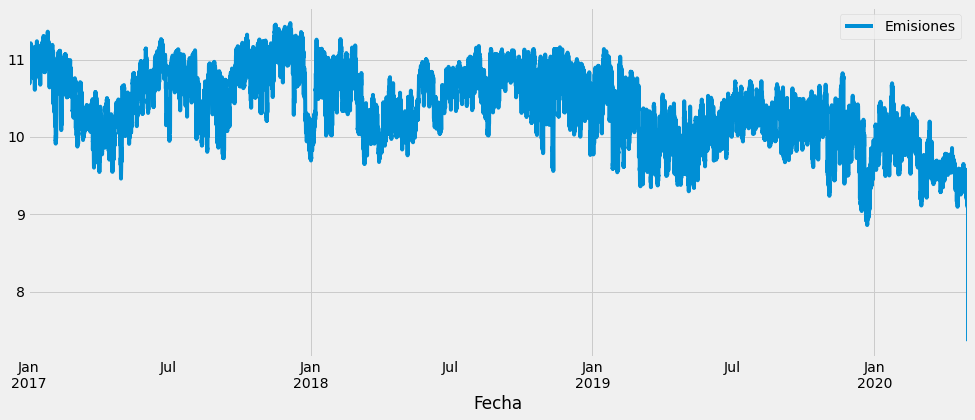

In [14]:
# line plot
dataset_log.plot(figsize=(15, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002598120E8C8>]],
      dtype=object)

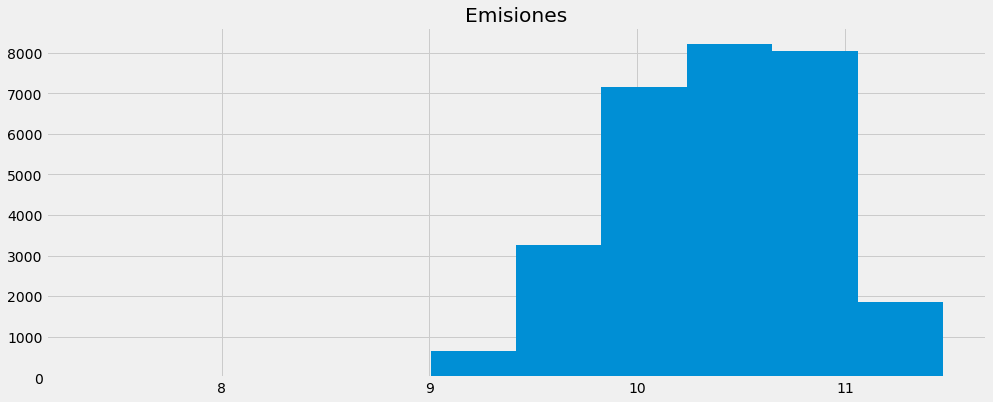

In [15]:
# hist plot
dataset_log.hist(figsize=(15, 6))

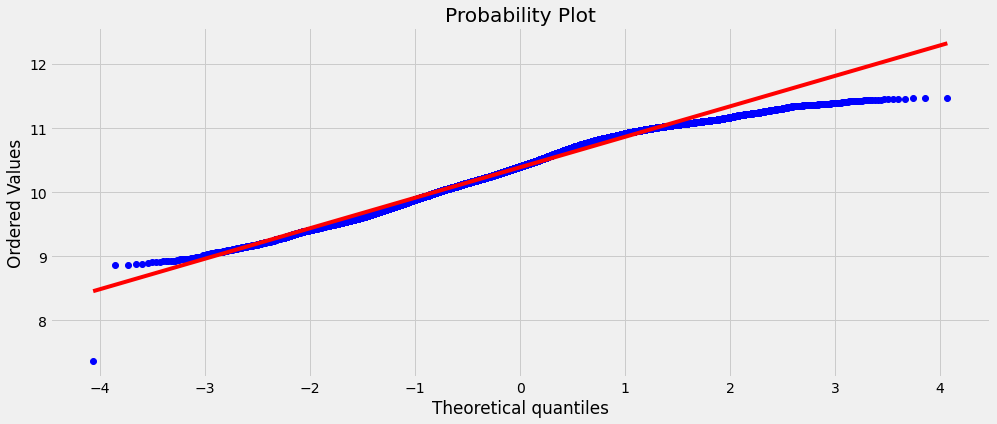

In [27]:
scipy.stats.probplot(dataset_log['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Box-Cox Transform

In [21]:
dataset_boxcox = dataset_by_hour.copy()
#dataset_box_transformation.columns = ['Emisiones']
dataset_boxcox['Emisiones'], lam = boxcox(dataset_boxcox['Emisiones'])

In [22]:
#dataset_box_transformation = pandas.DataFrame(dataset_by_hour.Emisiones)
#dataset_box_transformation.columns = ['Emisiones']
#dataset_box_transformation['Emisiones'], lam = boxcox(dataset_box_transformation['Emisiones'])

In [23]:
lam

0.2790298330248414

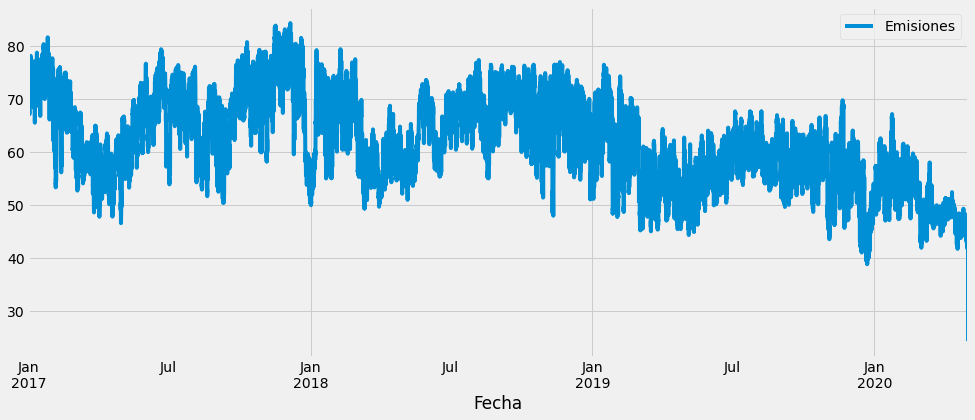

In [24]:
dataset_boxcox.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025981A58388>]],
      dtype=object)

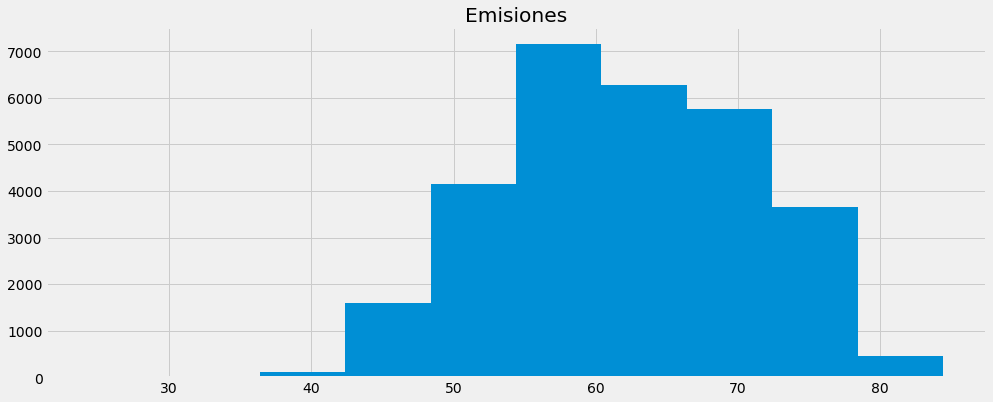

In [25]:
dataset_boxcox.hist()

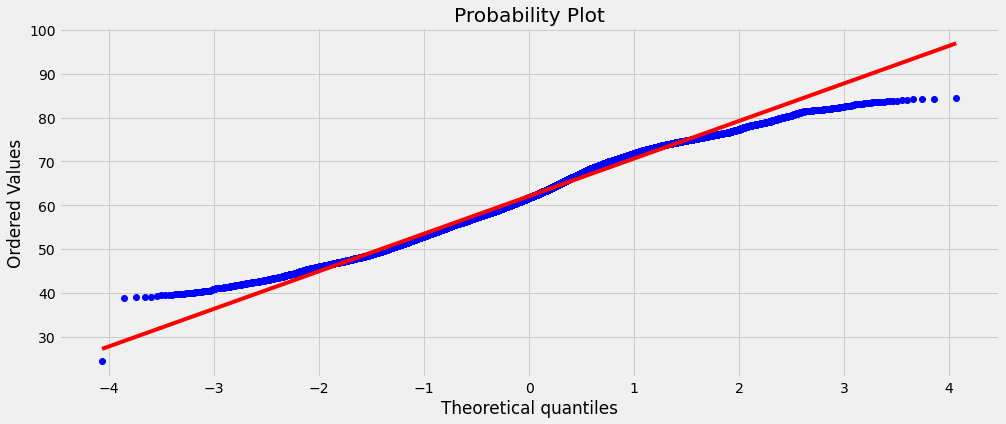

lambda parameter for Box-Cox Transformation is: 0.2790298330248414


In [26]:
scipy.stats.probplot(dataset_boxcox['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()
print ("lambda parameter for Box-Cox Transformation is:", lam)

# Prophet model
In this section we will apply different prophet models to two different dataset: The first is non-stationary and the second one is stationary

## Create the datasets
In order to apply Prophet to a dataset, it must have two specific columns names:
- 'ds' which are the timestamps
- 'y' which are the values
So we must rename 'Fecha' to 'ds' and 'Emisiones' to 'y'

**Creation of the non-stationary dataset**

In [210]:
# Create the dataset
prophet_dataset = dataset_by_hour

# Reset the index in order to be able to rename te columns
prophet_dataset = prophet_dataset.reset_index()
prophet_dataset = prophet_dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

prophet_dataset.head()

,ds,y
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97


**Creation of the stationary dataset**

To create it we must apply a logarithm transformation to the 'Emisiones' column, which is renamed as y

In [211]:
# Create the dataset
prophet_dataset_log = prophet_dataset
# Apply log transformation to have a normal distribution
prophet_dataset_log['y'] = numpy.sqrt(prophet_dataset_log['y'])

prophet_dataset_log.head()

,ds,y
0,2016-12-31 21:00:00,239.442039
1,2016-12-31 22:00:00,238.057409
2,2016-12-31 23:00:00,240.138918
3,2017-01-01 00:00:00,240.175020
4,2017-01-01 01:00:00,238.056653


## Fit the models
We must create two kinds of models:
- A model which fit additive timeseries
- A model which fit multiplicative timeseries

In [212]:
# Create the additive model
prophet_additive = Prophet()
# Create the multiplicative model
prophet_multiplicative = Prophet(seasonality_mode='multiplicative')

We will fit the additive model with the stationary data and the multiplicative model with the non-stationary data

In [213]:
# Fit both models
prophet_additive.fit(prophet_dataset_log)
prophet_multiplicative.fit(prophet_dataset)

Now we create the dates for which to make predictions

In [214]:
future_dates = prophet_additive.make_future_dataframe(periods=24, freq='H')
future_dates.tail()

,ds
29203,2020-05-01 16:00:00
29204,2020-05-01 17:00:00
29205,2020-05-01 18:00:00
29206,2020-05-01 19:00:00
29207,2020-05-01 20:00:00


## Forecast future dates

In [215]:
forecast_additive = prophet_additive.predict(future_dates)
forecast_additive[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29203,2020-05-01 16:00:00,124.132465,99.300198,150.170298
29204,2020-05-01 17:00:00,123.456777,97.424312,149.126822
29205,2020-05-01 18:00:00,124.750266,96.824879,150.197317
29206,2020-05-01 19:00:00,127.743460,100.488967,155.407594
29207,2020-05-01 20:00:00,130.503891,104.194523,155.859963


In [216]:
forecast_multiplicative = prophet_multiplicative.predict(future_dates)
forecast_multiplicative[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29203,2020-05-01 16:00:00,117.687394,93.018849,143.897713
29204,2020-05-01 17:00:00,117.271959,90.421303,143.204604
29205,2020-05-01 18:00:00,118.149039,93.766649,144.529680
29206,2020-05-01 19:00:00,120.120625,93.238699,146.399179
29207,2020-05-01 20:00:00,121.903353,96.079277,147.368009


**Plot the additive forecasts**

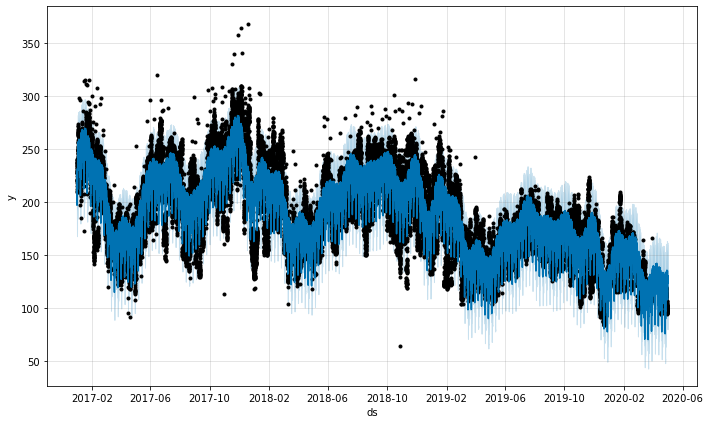

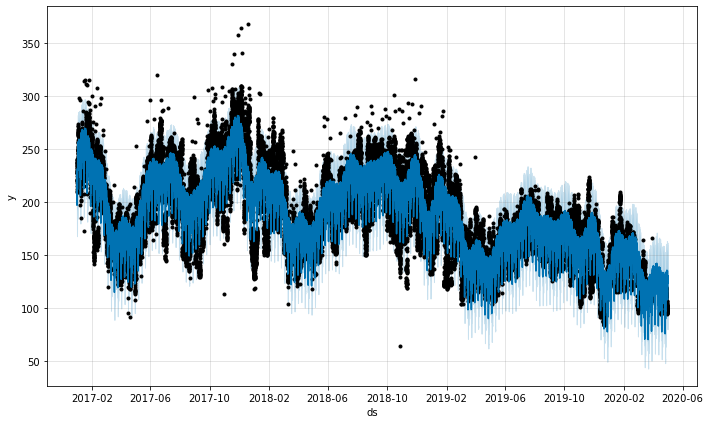

In [217]:
prophet_additive.plot(forecast_additive, uncertainty=True)

**Plot the multiplicative forecasts**

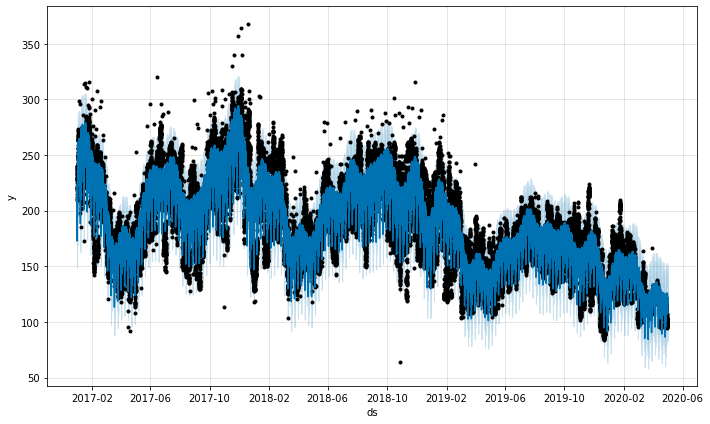

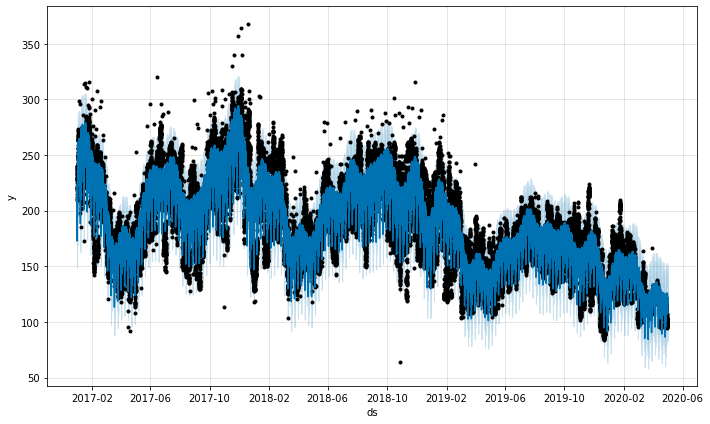

In [218]:
prophet_multiplicative.plot(forecast_multiplicative, uncertainty=True)

## Cross Validation and Perfomance Metrics
We will apply cross validation method and evaluate the perfomance metrics

**CAUTION: This process takes long running**

**Parameters:**
- **initial:** How many days use for train the data, in this case we will use the first 2 years (730 days)
- **period:** Once trained, how often do a prediction, in this case each 90 days
- **horizon:** How much time forecast, in this case 24 hours

In [ ]:
df_cv_additive = cross_validation(prophet_additive, initial='1095 days', period='24 days', horizon = '24 hours')
df_cv_additive.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-01-24 20:00:00 and 2020-04-29 20:00:00


In [ ]:
df_cv_multiplicative = cross_validation(prophet_multiplicative, initial='1095 days', period='24 days', horizon = '24 hours')
df_cv_multiplicative.head()

## Compare metrics
In order to compare the metrics we will apply exponential transformation to the additive results so both metrics are in the same scale

In [21]:
# Undo the log transformation to compare metrics in the same scale
df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

additive_metrics = performance_metrics(df_cv_additive)
additive_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,03:00:00,3.391672e+07,5823.806276,5145.675081,0.179447,0.176829,0.800000
1,04:00:00,3.377768e+07,5811.856879,5381.639686,0.214378,0.222389,0.716667
2,05:00:00,3.088350e+07,5557.292119,5188.515752,0.229799,0.201340,0.633333
3,06:00:00,2.607848e+07,5106.709461,4768.559756,0.226774,0.217364,0.600000
4,07:00:00,2.204411e+07,4695.115454,4438.941556,0.217333,0.204097,0.600000


In [22]:
df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

multiplicative_metrics = performance_metrics(df_cv_multiplicative)
multiplicative_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,03:00:00,3.022956e+07,5498.141656,5099.636238,0.176815,0.162765,0.800000
1,04:00:00,3.232335e+07,5685.362409,5431.812504,0.214774,0.214087,0.716667
2,05:00:00,3.124056e+07,5589.325241,5331.846023,0.233593,0.192431,0.633333
3,06:00:00,2.750407e+07,5244.432671,4982.780352,0.233395,0.222543,0.600000
4,07:00:00,2.393541e+07,4892.382864,4697.751948,0.225793,0.212138,0.600000


In [23]:
df_cv_multiplicative.tail(50)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
70,2019-07-04 19:00:00,32770.610460,24965.332538,43263.907908,43983.50,2019-07-03 20:00:00
71,2019-07-04 20:00:00,33999.255854,26224.399303,45004.238887,44594.50,2019-07-03 20:00:00
72,2019-10-01 21:00:00,33673.348906,25887.035699,44143.904858,30443.06,2019-10-01 20:00:00
73,2019-10-01 22:00:00,32726.688091,25009.753960,42621.884048,26852.68,2019-10-01 20:00:00
74,2019-10-01 23:00:00,30831.916758,23750.344891,39716.940586,24039.46,2019-10-01 20:00:00
75,2019-10-02 00:00:00,28736.341609,21950.348828,37463.970540,23010.24,2019-10-01 20:00:00
76,2019-10-02 01:00:00,27048.134754,20997.158559,35813.644697,22111.70,2019-10-01 20:00:00
77,2019-10-02 02:00:00,25987.630737,20136.647963,34127.810596,21269.32,2019-10-01 20:00:00
78,2019-10-02 03:00:00,25522.730150,19695.904932,33499.313753,21225.78,2019-10-01 20:00:00
79,2019-10-02 04:00:00,25600.877288,19539.175242,33379.067820,21283.04,2019-10-01 20:00:00


Looking both perfomance metrics, they are very similar but Prophet with the multiplicative option seems to perform better on large values

# ARIMA Model
In this section we will implement an ARIMA model to see if it performs better than Prophet

In [31]:
import itertools
import statsmodels.api as sm
pyplot.style.use('fivethirtyeight')

In [32]:
arima_dataset_train = dataset_by_hour[:"2020-03-31"].copy()
arima_dataset_train['Emisiones'], lam = boxcox(arima_dataset_train['Emisiones'])
#arima_dataset_train['Emisiones'] = numpy.log(arima_dataset_train['Emisiones'])
arima_dataset_test = dataset_by_hour["2020-04-01":].copy()

In [168]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

print('Examples of parameter combinations for Seasonal ARIMA...')
print('ARIMA: {} '.format(pdq[1]))
print('ARIMA: {} '.format(pdq[1]))
print('ARIMA: {} '.format(pdq[2]))
print('ARIMA: {} '.format(pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 0, 1) 
ARIMA: (0, 0, 1) 
ARIMA: (0, 1, 0) 
ARIMA: (0, 1, 0) 


## Grid Search
We will use Grid Search to find the best (p, d, q) values for the series. The model will return the AIC measures, in this case we are interested in the parameters which output the lowest AIC

**IMPORTANT: This takes 3 hours to output all the combinations**

In [169]:
arima_dataset = dataset_sqrt_transformation

for param in pdq:
        try:
            mod = mod = ARIMA(arima_dataset, order=param)

            results = mod.fit()

            print('ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue

ARIMA(0, 0, 0) - AIC:95873.24162886228
ARIMA(0, 0, 1) - AIC:67380.13520147183
ARIMA(0, 1, 0) - AIC:11564.924671470972
ARIMA(0, 1, 1) - AIC:11391.221972682237
ARIMA(1, 0, 0) - AIC:11304.118041827118
ARIMA(1, 0, 1) - AIC:11167.802251686451
ARIMA(1, 1, 0) - AIC:11355.482704095491
ARIMA(1, 1, 1) - AIC:10962.675215801442


Looking the outputs, the parameter combination which outputs a lower AIC values are the following:

(p, d, q)(P, D, Q)s = (0, 1, 1) (1, 1, 1, 12)12

## Fitting model
Now we will fit the model with the best parameter combination above

In [33]:
# Creates the model with custom parameters
mod = sm.tsa.statespace.SARIMAX(arima_dataset_train, order=(2, 0, 1),
                                seasonal_order=(3, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Train the model with the data
results = mod.fit(low_memory=True)

# Output some information
#print(results.summary())

In [34]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Emisiones   No. Observations:                28467
Model:             SARIMAX(2, 0, 1)x(3, 1, 1, 24)   Log Likelihood              -22110.539
Date:                            Sun, 21 Jun 2020   AIC                          44237.078
Time:                                    20:09:35   BIC                          44303.102
Sample:                                12-31-2016   HQIC                         44258.319
                                     - 03-31-2020                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2808      0.015     85.258      0.000       1.251       1.310
ar.L2         -0.2941      0.015   

From the table above, the 'coef' column show the weight importance of each term an how each one impacts the time series. The The P>|z| column informs us of the significance of each feature weight. 

Here, each weight has a p-value of 0 and none of the term's coefficients is really close to 0, so it is reasonable to retain them in our model.

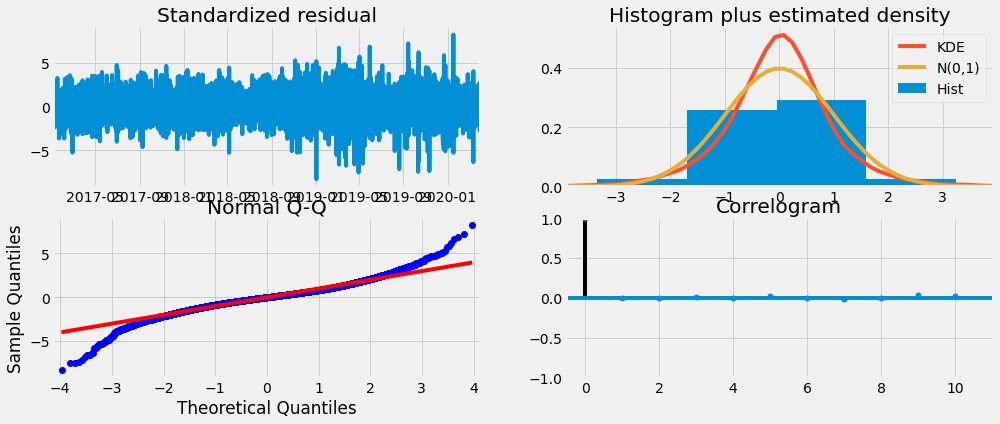

In [35]:
results.plot_diagnostics()
pyplot.show()

Let's analyze the plots above:
- **Top Left:** The residual error fluctuate around a mean of zero but seems to have a deacreasing trend
- **Top Right:** The density plot doesn't suggest a normal distribution, it seems to be skewed
- **Bottom Left:** Distribution skewed confirmed, otherwise the dots would fall perfectly in line with the red line
- **Bottom Righ:** It shows some autocorrelation

Due to the skewed data, we will have to apply some transformation to it in order to make it stationary

In [36]:
predictions = results.get_forecast(steps=48)

In [37]:
predictions.predicted_mean

2020-04-01 00:00:00    45.207819
2020-04-01 01:00:00    44.875162
2020-04-01 02:00:00    44.847763
2020-04-01 03:00:00    44.793446
2020-04-01 04:00:00    44.783885
2020-04-01 05:00:00    44.925440
2020-04-01 06:00:00    45.142319
2020-04-01 07:00:00    45.449613
2020-04-01 08:00:00    45.372680
2020-04-01 09:00:00    45.223673
2020-04-01 10:00:00    44.943058
2020-04-01 11:00:00    44.962328
2020-04-01 12:00:00    45.195070
2020-04-01 13:00:00    45.175556
2020-04-01 14:00:00    45.254074
2020-04-01 15:00:00    44.836814
2020-04-01 16:00:00    44.537658
2020-04-01 17:00:00    44.681248
2020-04-01 18:00:00    45.127613
2020-04-01 19:00:00    45.374445
2020-04-01 20:00:00    45.641028
2020-04-01 21:00:00    45.724110
2020-04-01 22:00:00    45.457152
2020-04-01 23:00:00    45.376879
2020-04-02 00:00:00    45.062567
2020-04-02 01:00:00    44.696551
2020-04-02 02:00:00    44.607768
2020-04-02 03:00:00    44.516111
2020-04-02 04:00:00    44.554812
2020-04-02 05:00:00    44.632530
2020-04-02

In [38]:
predictions.predicted_mean = scipy.special.inv_boxcox(predictions.predicted_mean, lam)
#predictions.predicted_mean = numpy.exp(predictions.predicted_mean)

In [39]:
predictions.predicted_mean

2020-04-01 00:00:00    15278.082627
2020-04-01 01:00:00    14892.433576
2020-04-01 02:00:00    14860.991160
2020-04-01 03:00:00    14798.802698
2020-04-01 04:00:00    14787.876543
2020-04-01 05:00:00    14950.257501
2020-04-01 06:00:00    15201.576443
2020-04-01 07:00:00    15562.954727
2020-04-01 08:00:00    15471.896600
2020-04-01 09:00:00    15296.643232
2020-04-01 10:00:00    14970.559046
2020-04-01 11:00:00    14992.786466
2020-04-01 12:00:00    15263.169336
2020-04-01 13:00:00    15240.363297
2020-04-01 14:00:00    15332.280764
2020-04-01 15:00:00    14848.439880
2020-04-01 16:00:00    14508.509515
2020-04-01 17:00:00    14670.950720
2020-04-01 18:00:00    15184.437359
2020-04-01 19:00:00    15473.981253
2020-04-01 20:00:00    15791.218750
2020-04-01 21:00:00    15891.055166
2020-04-01 22:00:00    15571.898673
2020-04-01 23:00:00    15476.855691
2020-04-02 00:00:00    15108.803172
2020-04-02 01:00:00    14688.340997
2020-04-02 02:00:00    14587.657962
2020-04-02 03:00:00    14484

In [40]:
prediction_df = pandas.DataFrame(predictions.predicted_mean)

In [41]:
prediction_df = prediction_df.rename({0: "Emisiones"}, axis='columns')

In [42]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-04-01 00:00:00 to 2020-04-02 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Emisiones  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [43]:
prediction_df["Real"] = arima_dataset_test["Emisiones"].copy()

In [44]:
prediction_df.head()

,Emisiones,Real
2020-04-01 00:00:00,15278.082627,15557.14
2020-04-01 01:00:00,14892.433576,15774.73
2020-04-01 02:00:00,14860.991160,15671.16
2020-04-01 03:00:00,14798.802698,15775.74
2020-04-01 04:00:00,14787.876543,16164.29


In [45]:
metrics = evaluator.regression_perfomance_metrics(prediction_df['Real'], prediction_df['Emisiones'])

In [46]:
print(metrics)

{'MAE': 970.0982976270408, 'MSE': 1442811.8645653287, 'RMSE': 1201.171038847228, 'R^2': -0.3867365996681764, 'MAPE': 5.949691270086847}


## Validating forecast
We will produce a forecast of a small period in order to validate it and apply the forecast in larger predictions

In [ ]:
X = arima_dataset.Emisiones
forecast_points = [0.7, 0.8, 0.9]
sizes = [int(len(X) * point) for point in forecast_points]

train, test = [X[0:size], X[size:len(X)] for size in sizes]

histories = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=15.158414, expected=15.231867
predicted=15.185340, expected=15.247023
predicted=15.202094, expected=15.165219
predicted=15.131087, expected=15.180807
predicted=15.147417, expected=14.966769
predicted=14.956106, expected=14.841571
predicted=14.843617, expected=14.769282
predicted=14.778124, expected=14.815722
predicted=14.819525, expected=14.888245
predicted=14.884834, expected=15.080577
predicted=15.058926, expected=15.227588
predicted=15.193244, expected=15.285723
predicted=15.248051, expected=15.260184
predicted=15.227434, expected=14.994007
predicted=14.988953, expected=14.604862
predicted=14.637481, expected=14.054811
predicted=14.138008, expected=13.455207
predicted=13.590240, expected=13.072186
predicted=13.234802, expected=12.935281
predicted=13.100208, expected=12.844939
predicted=13.007617, expected=12.929342
predicted=13.073339, expected=13.449487
predicted=13.534550, expected=14.105935
predicted=14.122792, expected=14.626841
predicted=14.592870, expected=14.761496
